In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

In [2]:
# ==========================================
# 1. สร้างพิมพ์เขียว "Residual Block" (ก้อนอิฐ)
# ==========================================
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        
        # Conv ตัวที่ 1
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, 
                               stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        
        # Conv ตัวที่ 2
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, 
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        # --- ส่วนสำคัญ: Shortcut Connection (ทางลัด) ---
        # ถ้าขนาดภาพเปลี่ยน (stride > 1) หรือจำนวน Channel เปลี่ยน
        # เราต้องปรับขนาดของ input (x) ให้เท่ากับ output เพื่อให้ "บวก" กันได้
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        
        # === หัวใจของ ResNet: การบวก (Addition) ===
        # เอาผลลัพธ์ใหม่ (out) บวกกับ ของเดิม (shortcut(x))
        out += self.shortcut(x) 
        
        out = F.relu(out)
        return out

In [3]:
# ==========================================
# 2. สร้างโมเดล ResNet (บ้านทั้งหลัง)
# ==========================================
class ResNetCIFAR(nn.Module):
    def __init__(self, num_classes=10):
        super(ResNetCIFAR, self).__init__()
        
        # 1. ชั้นแรก (Prep Layer)
        # รับภาพ RGB 3 channels -> ขยายเป็น 16 channels
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        
        # 2. สร้าง Layer ต่อๆ กัน (Stack of Blocks)
        # Layer 1: 16 channels (ขนาดภาพ 32x32)
        self.layer1 = self._make_layer(16, 16, num_blocks=2, stride=1)
        # Layer 2: 32 channels (ขนาดภาพ 16x16) -> เริ่มลดขนาดตรงนี้
        self.layer2 = self._make_layer(16, 32, num_blocks=2, stride=2)
        # Layer 3: 64 channels (ขนาดภาพ 8x8)
        self.layer3 = self._make_layer(32, 64, num_blocks=2, stride=2)
        
        # 3. Output Layer
        self.fc = nn.Linear(64, num_classes)

    def _make_layer(self, in_channels, out_channels, num_blocks, stride):
        layers = []
        # บล็อกแรกอาจมีการลดขนาด (stride)
        layers.append(ResidualBlock(in_channels, out_channels, stride))
        
        # บล็อกที่เหลือขนาดเท่าเดิม
        for _ in range(1, num_blocks):
            layers.append(ResidualBlock(out_channels, out_channels, stride=1))
            
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        
        # Global Average Pooling (8x8 -> 1x1)
        out = F.avg_pool2d(out, 8)
        out = out.view(out.size(0), -1) # Flatten
        out = self.fc(out)
        return out

In [4]:
num_classes = 10
learning_rate = 0.001
epochs = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
# Transform
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [6]:
# Dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False, num_workers=2)

In [7]:
# Init Model
model = ResNetCIFAR(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

Start Training ResNet (MSE Strategy)...
Epoch [1/10] Train MSE: 2.017992 | Test MSE: 1.928654
Epoch [2/10] Train MSE: 1.873025 | Test MSE: 1.841723
Epoch [3/10] Train MSE: 1.820782 | Test MSE: 1.805742
Epoch [4/10] Train MSE: 1.781261 | Test MSE: 1.815382
Epoch [5/10] Train MSE: 1.754008 | Test MSE: 1.780797
Epoch [6/10] Train MSE: 1.732497 | Test MSE: 1.748033
Epoch [7/10] Train MSE: 1.710498 | Test MSE: 1.734865
Epoch [8/10] Train MSE: 1.697497 | Test MSE: 1.718358
Epoch [9/10] Train MSE: 1.680338 | Test MSE: 1.702711
Epoch [10/10] Train MSE: 1.671608 | Test MSE: 1.707874
Finished Training


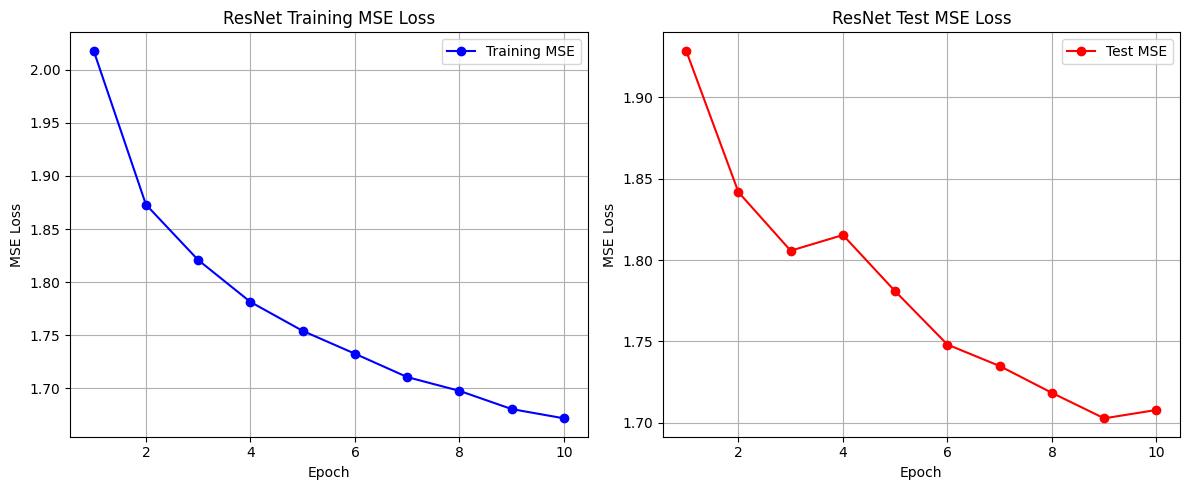

In [ ]:
epoch_losses = []     
epoch_test_losses = [] 

print("Start Training ResNet (MSE Strategy)...")
for epoch in range(epochs):
    running_loss = 0.0
    
    # --- Training Phase ---
    model.train()
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # [MSE Change 1] Labels to One-Hot
        labels_one_hot = F.one_hot(labels, num_classes=10).float()

        optimizer.zero_grad()
        outputs = model(inputs)
        
        # [MSE Change 2] Softmax outputs
        outputs_prob = F.softmax(outputs, dim=1)
        
        loss = criterion(outputs_prob, labels_one_hot)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(trainloader)
    epoch_losses.append(avg_loss)

    # --- Evaluation Phase (Calculating Test MSE) ---
    model.eval()
    test_running_loss = 0.0
    
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            
            # [MSE Change 3] Apply same transforms for Test data
            labels_one_hot = F.one_hot(labels, num_classes=10).float()
            outputs_prob = F.softmax(outputs, dim=1)
            
            loss = criterion(outputs_prob, labels_one_hot)
            test_running_loss += loss.item()
    
    avg_test_loss = test_running_loss / len(testloader)
    epoch_test_losses.append(avg_test_loss)
    
    print(f'Epoch [{epoch+1}/{epochs}] Train MSE: {avg_loss:.6f} | Test MSE: {avg_test_loss:.6f}')

print('Finished Training')

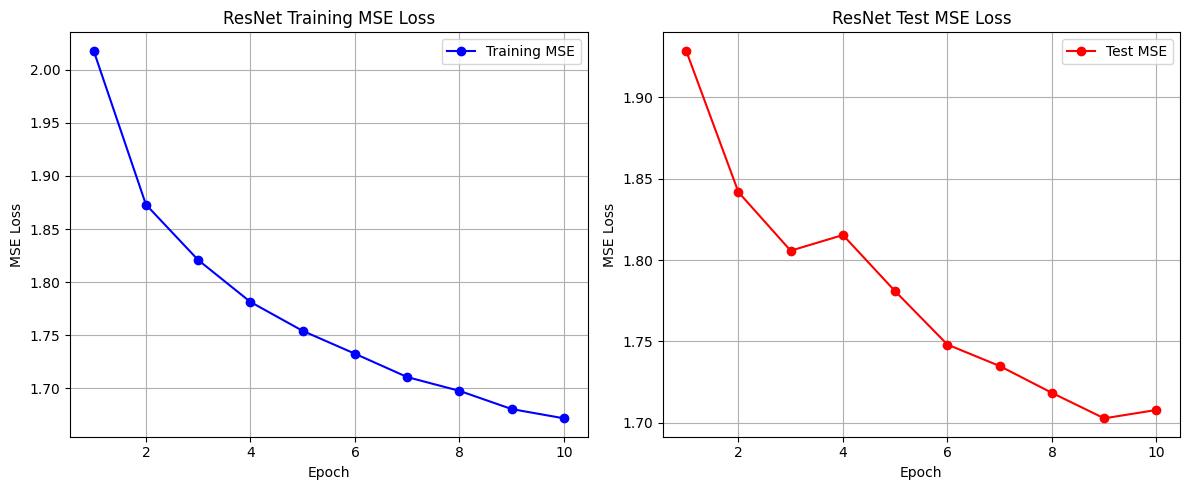

In [9]:
# ==========================================
# 3. Plotting MSE for both Train and Test
# ==========================================
plt.figure(figsize=(12, 5))

# Plot Training MSE
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), epoch_losses, 'b-o', label='Training MSE')
plt.title('ResNet Training MSE Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.grid(True)
plt.legend()

# Plot Test MSE
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), epoch_test_losses, 'r-o', label='Test MSE')
plt.title('ResNet Test MSE Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()